<a href="https://colab.research.google.com/github/AdamAnderB/AOW_practice/blob/main/Working_HDDM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install virtualenv
!virtualenv venv
!source venv/bin/activate

!pip install pymc==5.6.0
!pip install ssm-simulators==0.3.1
!pip install huggingface-hub>=0.16.4
!pip install blackjax
!pip install graphviz

!pip install numpy==1.23.4
!pip install git+https://github.com/lnccbrown/hssm@main
!pip install git+https://github.com/brown-ccv/hddm-wfpt@main
!pip install numpyro

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.9/468.9 kB 18.9 MB/s eta 0:00:00
created virtual environment CPython3.10.12.final.0-64 in 1496ms
  creator CPython3Posix(dest=/content/venv, clear=False, no_vcs_ignore=False, global=False)
  seeder FromAppData(download=False, pip=bundle, setuptools=bundle, wheel=bundle, via=copy, app_data_dir=/root/.local/share/virtualenv)
    added seed packages: pip==23.3.1, setuptools==69.0.2, wheel==0.42.0
  activators BashActivator,CShellActivator,FishActivator,NushellActivator,PowerShellActivator,PythonActivator
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 450.7/450.7 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 36.5 MB/s eta 0:00:00
  Attempting uninstall: pytensor
    Found existing installation: pytensor 2.14.2
    Uninstalling pytensor-2.14.2:
      Successfully uninstalled pytensor-2.14.2
  Attempting uninstall: pymc
    Found e

  Cloning https://github.com/lnccbrown/hssm (to revision main) to /tmp/pip-req-build-r2nobyuu
  Running command git clone --filter=blob:none --quiet https://github.com/lnccbrown/hssm /tmp/pip-req-build-r2nobyuu
  Resolved https://github.com/lnccbrown/hssm to commit de4898497b26f1ddcba99e9c41e3415ff30d360a
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.4/79.4 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 758.0/758.0 kB 52.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 304.6/304.6 kB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 82.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 98.6 MB/s e

In [3]:
from ssms.basic_simulators import simulator
import numpy as np
import pandas as pd

# Basics
import os
import sys
import time
import jax

from matplotlib import pyplot as plt
import arviz as az  # Visualization
import pytensor  # Graph-based tensor library
import hssm

# import ssms.basic_simulators # Model simulators
import hddm_wfpt
import bambi as bmb

# Setting float precision in pytensor
pytensor.config.floatX = "float32"

from jax.config import config

jax.config.update("jax_enable_x64", False)
!pip install --upgrade --force-reinstall scipy

<ipython-input-3-9c4ccaddfe81>:23: DeprecationWarning: Accessing jax.config via the jax.config submodule is deprecated.
  from jax.config import config


  Using cached scipy-1.11.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (36.4 MB)
  Using cached numpy-1.26.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.2 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.4
    Uninstalling numpy-1.23.4:
      Successfully uninstalled numpy-1.23.4
  Attempting uninstall: scipy
    Found existing installation: scipy 1.10.1
    Uninstalling scipy-1.10.1:
      Successfully uninstalled scipy-1.10.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.
cupy-cuda11x 11.0.0 requires numpy<1.26,>=1.20, but you have numpy 1.26.2 which is incompatible.
hssm 0.

In [4]:
# Specify parameters
v_true, a_true, z_true, t_true = [0.5, 1.5, 0.5, 0.2]


# Simulate data
sim_out = simulator.simulator(
    theta=[v_true, a_true, z_true, t_true],  # parameter list
    model="ddm",  # specify model (many are included in ssms)
    n_samples=500,  # number of samples for each set of parameters
)

# Turn into nice dataset
# Turn data into a pandas dataframe
dataset = pd.DataFrame(
    np.column_stack([sim_out["rts"][:, 0], sim_out["choices"][:, 0]]),
    columns=["rt", "response"],
)

dataset

,rt,response
0,1.397753,1.0
1,0.610055,1.0
2,6.601692,1.0
3,1.412859,1.0
4,3.430459,1.0
...,...,...
495,0.843187,1.0
496,0.541810,1.0
497,1.371123,1.0
498,1.245129,1.0


In [41]:
from google.colab import files

uploaded = files.upload()


Saving sp_24_HDDM_music_data.csv to sp_24_HDDM_music_data (1).csv


In [67]:
file_name = list(uploaded.keys())[0]
# Read the CSV file into a Pandas DataFrame
df = pd.read_csv(file_name)
df.head()

,Unnamed: 0,Participant.Private.ID,Trial.Number,Spreadsheet.Name,Reaction.Time,rt_correct,Answer_correct,melody_score,beat_score,centered_beats,centered_melody
0,1,9353724,1,Mandarin,318.0,318.0,1,1.0,0.966667,0.649675,0.655506
1,2,9353724,2,Mandarin,369.0,369.0,1,1.0,0.966667,0.649675,0.655506
2,3,9353724,3,Mandarin,339.0,339.0,1,1.0,0.966667,0.649675,0.655506
3,4,9353724,4,Mandarin,609.0,609.0,1,1.0,0.966667,0.649675,0.655506
4,5,9353724,5,Mandarin,450.0,450.0,1,1.0,0.966667,0.649675,0.655506


In [90]:
#adduseful columns
df['rt'] = df['Reaction.Time']
df['response'] = df['Answer_correct']
df = df[df['Spreadsheet.Name'] == 'Mandarin']

# Display the updated DataFrame
df['response'] = df['response'].replace({0: -1})
df1 = df[['rt', 'response']]



summary = df1.describe()
print(summary)
df1.head()
#pd.set_option('display.max_rows', None)
#pd.set_option('display.max_columns', None)

# Display the DataFrame
#df1


                rt     response
count  3434.000000  3434.000000
mean    373.968375     0.846826
std     225.827034     0.531948
min       0.000000    -1.000000
25%     215.575000     1.000000
50%     319.200000     1.000000
75%     494.950000     1.000000
max    1081.500000     1.000000


,rt,response
0,318.0,1
1,369.0,1
2,339.0,1
3,609.0,1
4,450.0,1


In [69]:
simple_ddm_model = hssm.HSSM(data=df1)

In [70]:
print(simple_ddm_model)

Hierarchical Sequential Sampling Model
Model: ddm

Response variable: rt,response
Likelihood: analytical
Observations: 3434

Parameters:

v:
    Prior: Normal(mu: 0.0, sigma: 2.0)
    Explicit bounds: (-inf, inf)
a:
    Prior: HalfNormal(sigma: 2.0)
    Explicit bounds: (0.0, inf)
z:
    Prior: Uniform(lower: 0.0, upper: 1.0)
    Explicit bounds: (0.0, 1.0)
t:
    Prior: HalfNormal(sigma: 2.0, initval: 0.10000000149011612)
    Explicit bounds: (0.0, inf)

Lapse probability: 0.05
Lapse distribution: Uniform(lower: 0.0, upper: 10.0)


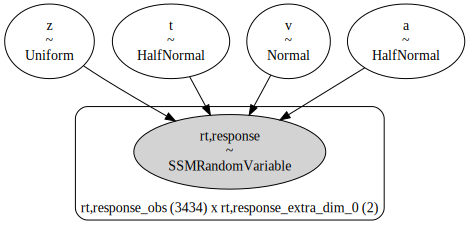

In [71]:
simple_ddm_model.graph()

In [73]:
#pip install --upgrade --force-reinstall scipy

  Using cached scipy-1.11.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (36.4 MB)
ERROR: Operation cancelled by user


In [84]:
infer_data_simple_ddm_model = simple_ddm_model.sample(
    sampler="nuts_numpyro",  # type of sampler to choose, 'nuts_numpyro', 'nuts_blackjax' of default pymc nuts sampler
    cores=1,  # how many cores to use
    chains=2,  # how many chains to run
    draws=500,  # number of draws from the markov chain
    tune=500,  # number of burn-in samples
    idata_kwargs=dict(log_likelihood=False),  # return log likelihood
)  # mp_ctx="forkserver")

/usr/local/lib/python3.10/dist-packages/jax/_src/numpy/array_methods.py:733: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [85]:
type(infer_data_simple_ddm_model)

arviz.data.inference_data.InferenceData

In [86]:
infer_data_simple_ddm_model

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [87]:
az.summary(infer_data_simple_ddm_model)


/usr/local/lib/python3.10/dist-packages/arviz/stats/diagnostics.py:584: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
v,0.137,0.078,0.059,0.215,0.055,0.046,2.0,2.0,14462920.06
z,0.560,0.169,0.391,0.729,0.118,0.100,2.0,2.0,14462920.06
t,0.087,0.021,0.065,0.108,0.015,0.013,2.0,2.0,14462920.06
a,2.449,0.954,1.496,3.403,0.669,0.565,2.0,2.0,14462920.06


/usr/local/lib/python3.10/dist-packages/arviz/utils.py:134: UserWarning: Items starting with ~: ['log_likelihood'] have not been found and will be ignored
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/usr/local/lib/python3.10/dist-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/usr/local/lib/python3.10/dist-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/usr/local/lib/python3.10/dist-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite val

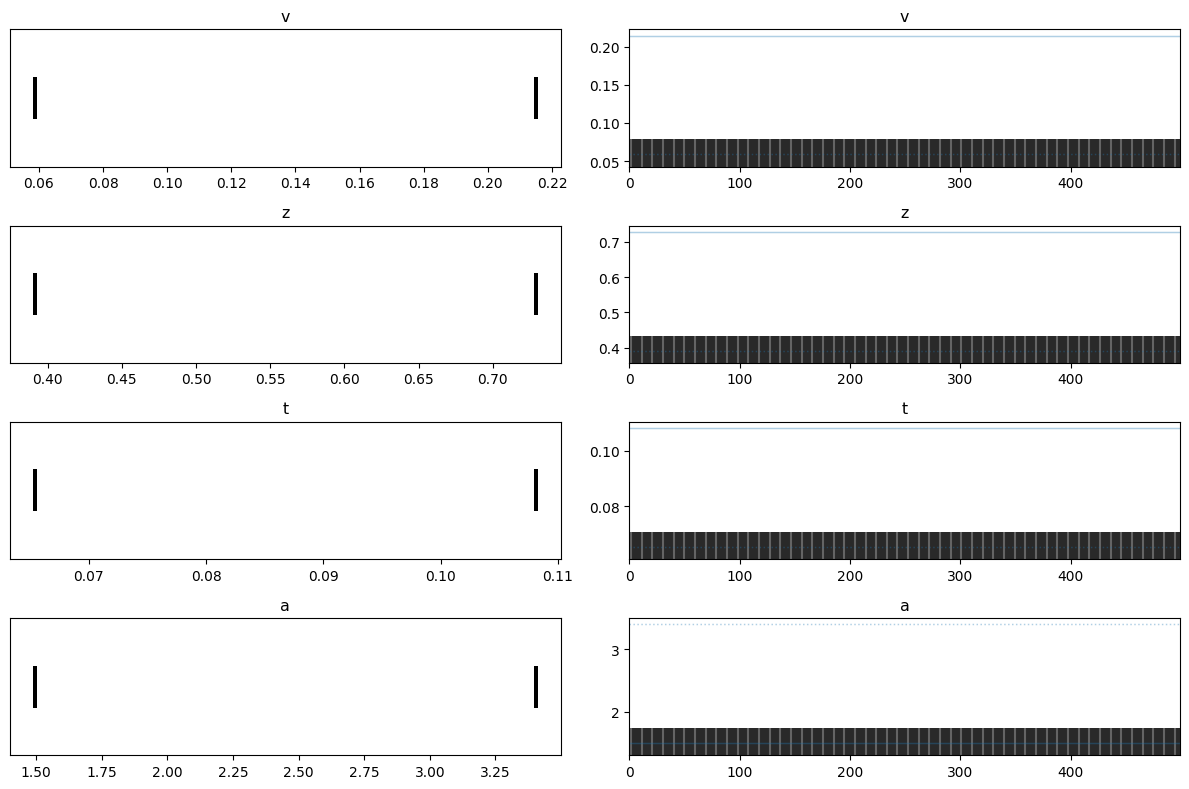

In [88]:
az.plot_trace(
    infer_data_simple_ddm_model,
    var_names="~log_likelihood",  # we exclude the log_likelihood traces here
)
plt.tight_layout()

In [79]:
constant_values = np.all(df1 == df1.iloc[0], axis=0)
print(constant_values)
# Check for NaN values
nan_values = df1.isnull().any()
print(nan_values)

rt          False
response    False
dtype: bool
rt          False
response    False
dtype: bool


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

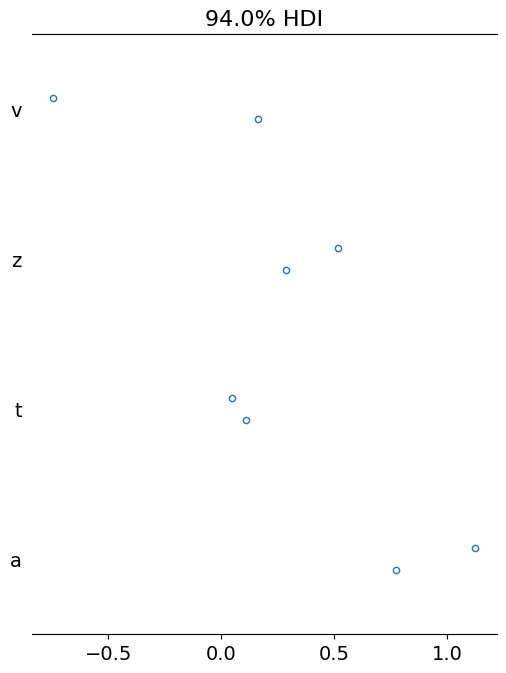

In [80]:
az.plot_forest(simple_ddm_model.traces)

array([<Axes: title={'center': 'v'}>, <Axes: title={'center': 'z'}>,
       <Axes: title={'center': 't'}>, <Axes: title={'center': 'a'}>],
      dtype=object)

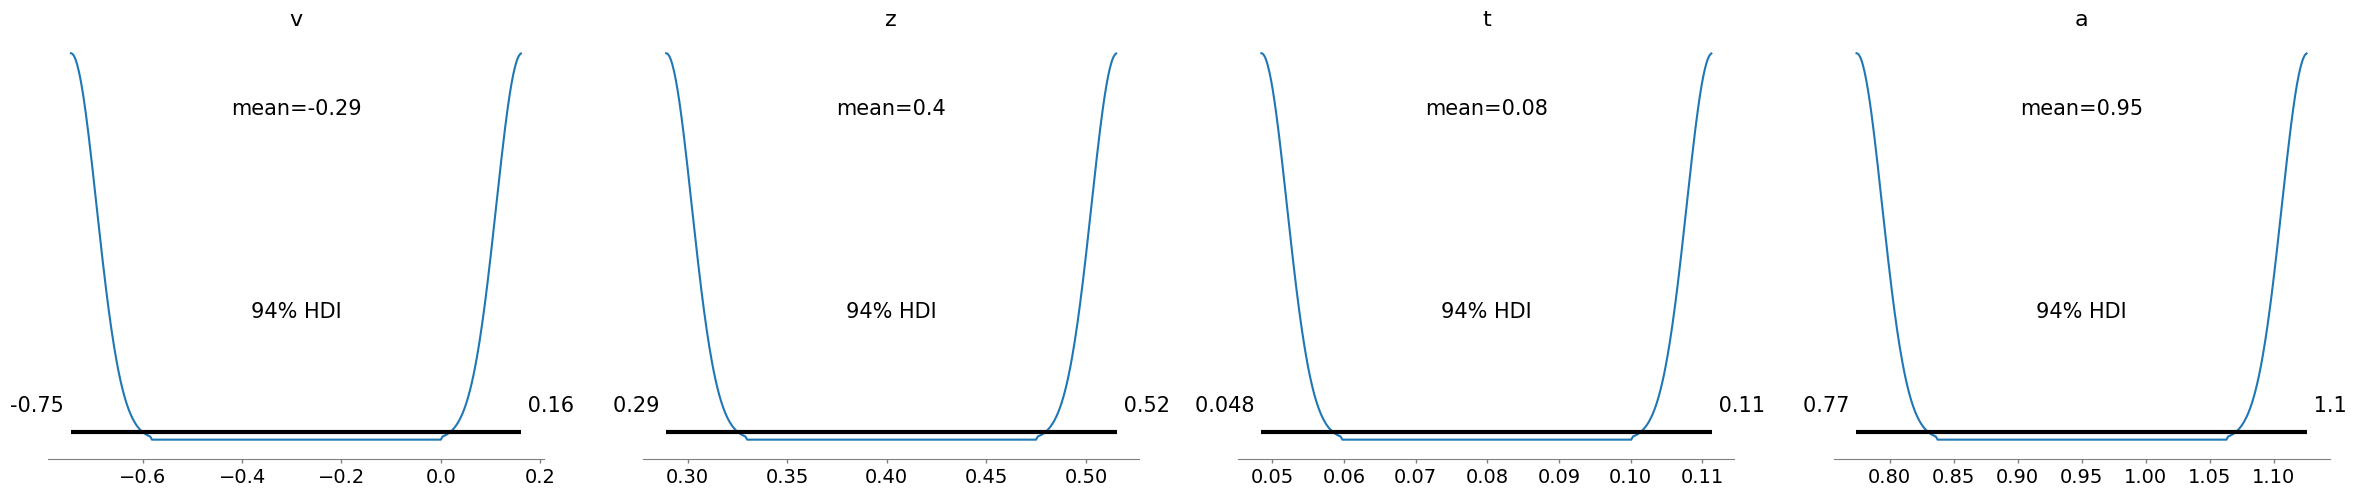

In [81]:
az.plot_posterior(simple_ddm_model.traces)

array([[<Axes: ylabel='z'>, <Axes: >, <Axes: >],
       [<Axes: ylabel='t'>, <Axes: >, <Axes: >],
       [<Axes: xlabel='v', ylabel='a'>, <Axes: xlabel='z'>,
        <Axes: xlabel='t'>]], dtype=object)

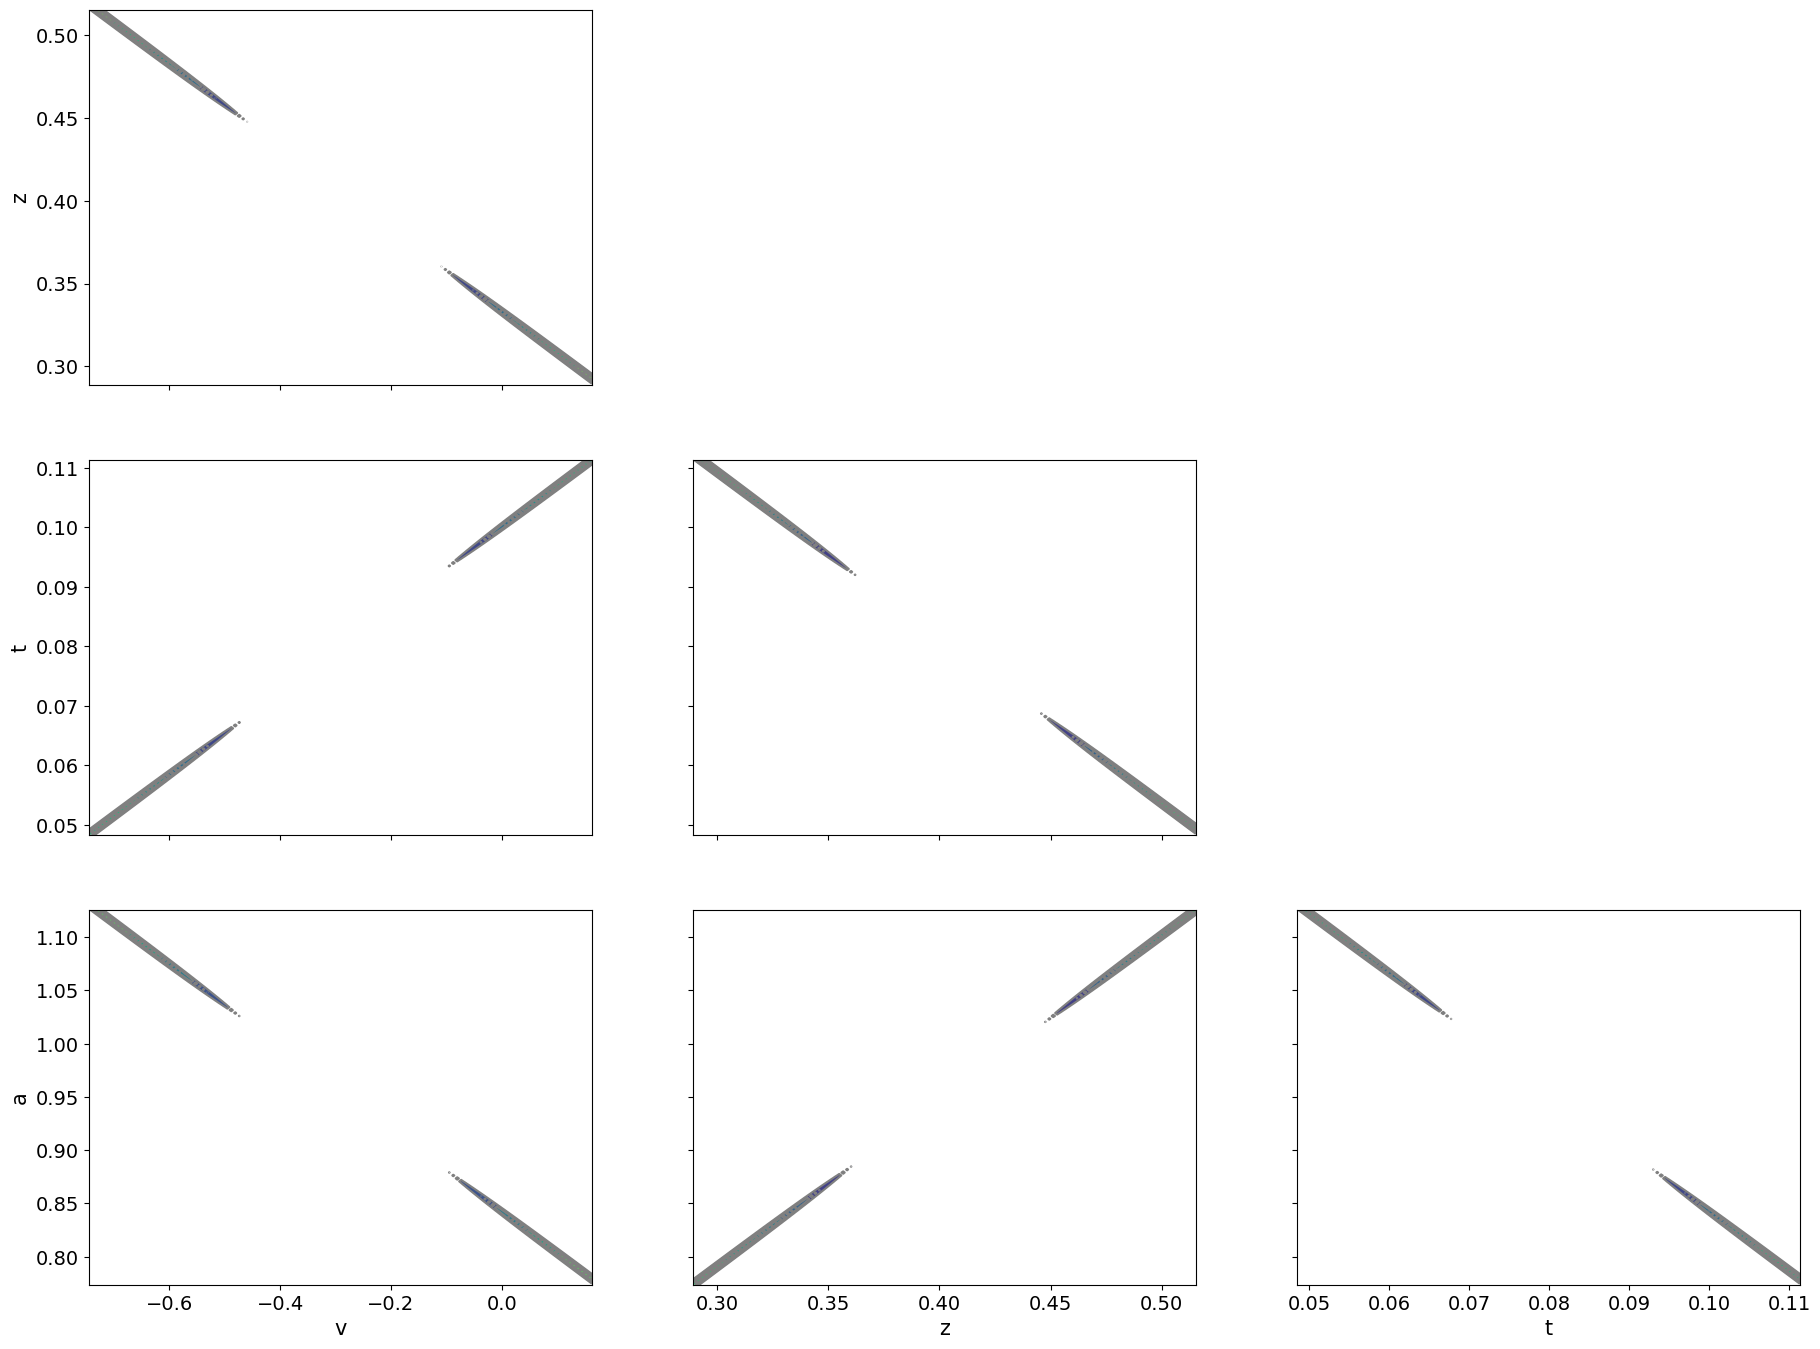

In [82]:
az.plot_pair(simple_ddm_model.traces, kind="kde")

In [83]:
simple_ddm_model.loglik_kind

'analytical'

complex model

In [ ]:
model_reg_v_angle_hier = hssm.HSSM(
    data=dataset_reg_v_hier,
    model="angle",
    include=[
        {
            "name": "v",
            "prior": {
                "Intercept": {
                    "name": "Uniform",
                    "lower": -3.0,
                    "upper": 3.0,
                    "initval": 0.0,
                },
                "x": {"name": "Uniform", "lower": -1.0, "upper": 1.0, "initval": 0.0},
                "y": {"name": "Uniform", "lower": -1.0, "upper": 1.0, "initval": 0.0},
            },
            "formula": "v ~ 1 + (1|subject) + x + y",
            "link": "identity",
        }
    ],
)